<a href="https://colab.research.google.com/github/rouchi-11/Image_Processing/blob/main/Assignment_6/Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Consider any image dataset with raw images containing noise, distortion etc. Apply filtering
techniques and implement Inverse filter and Wiener filter over the set of images in the dataset for
image restoration and comment on these two filtering effects.

 Please upload a ZIP file containing images...


Saving archive (5).zip to archive (5).zip
 Found 80 images in dataset


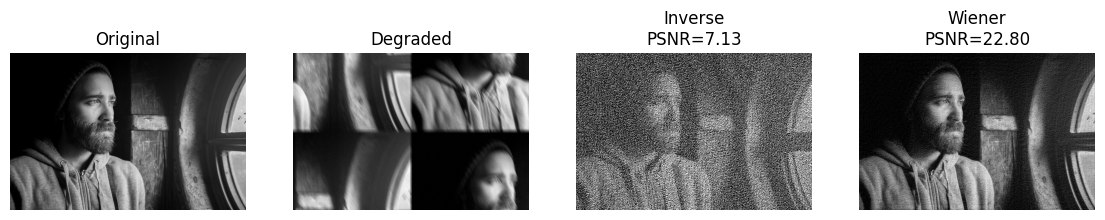

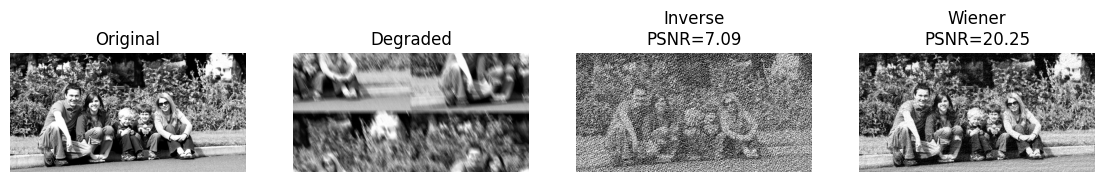

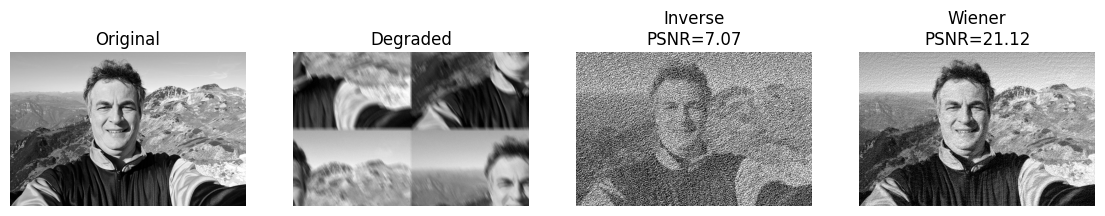

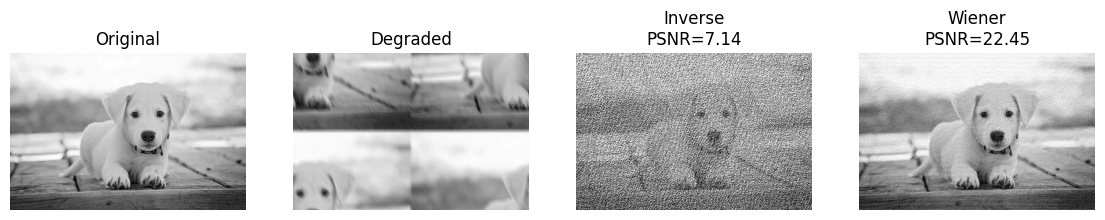

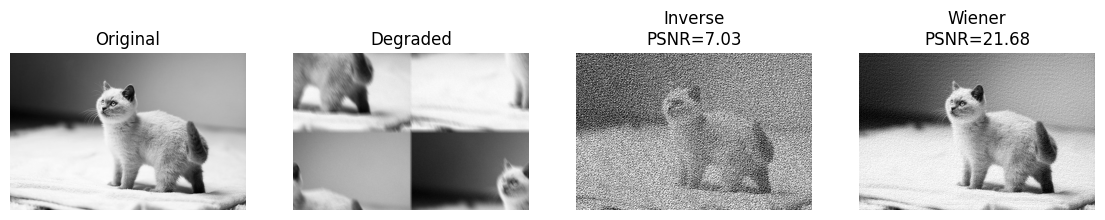

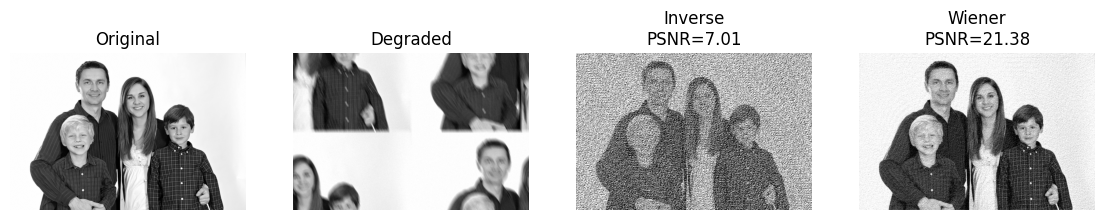

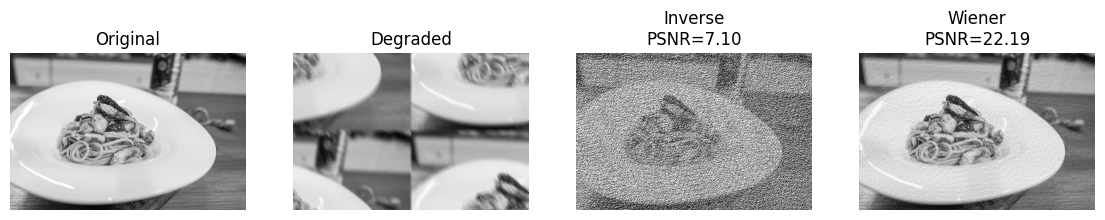

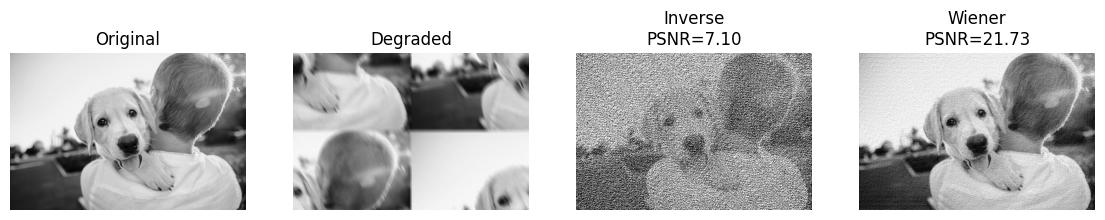

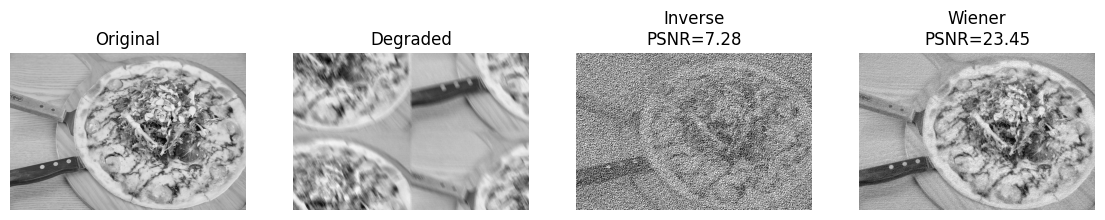

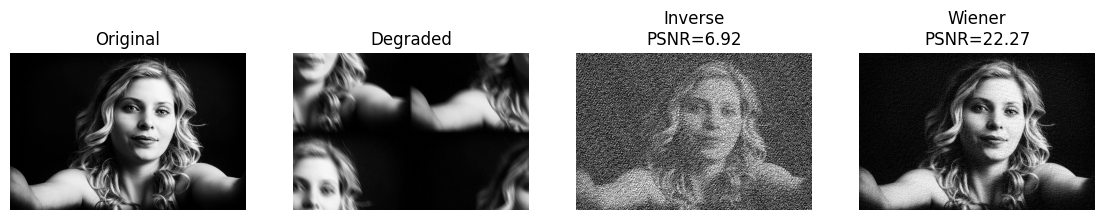


 Summary of Results:
                        Image  PSNR_Inverse  PSNR_Wiener  SSIM_Inverse  \
0   beanie-g4c423e47b_640.jpg      7.132554    22.797608      0.020676   
1   family-g441413fcc_640.jpg      7.089240    20.247995      0.100164   
2   selfie-g46d822e69_640.jpg      7.074107    21.119656      0.034394   
3    puppy-ge9d742e37_640.jpg      7.139883    22.447665      0.014016   
4      cat-g4fe5d8c20_640.jpg      7.030934    21.679386      0.014203   
5  sibling-g1003a623b_640.jpg      7.009198    21.377390      0.035546   
6     cave-g68bd31d20_640.jpg      7.096237    22.189080      0.019005   
7      dog-g7dcd325a6_640.jpg      7.103264    21.726082      0.014569   
8    pizza-gbc9c3ad3c_640.jpg      7.283849    23.450738      0.033572   
9     girl-gb9f87fafe_640.jpg      6.916871    22.269085      0.026866   

   SSIM_Wiener  
0     0.348192  
1     0.667285  
2     0.443558  
3     0.298612  
4     0.253013  
5     0.367929  
6     0.315297  
7     0.275228  
8     0.52

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:


import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float, img_as_ubyte
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from numpy.fft import fft2, ifft2
import zipfile, os, glob
from google.colab import files
import pandas as pd
import shutil



print(" Please upload a ZIP file containing images...")
uploaded = files.upload()

# Extract uploaded ZIP
for fname in uploaded.keys():
    with zipfile.ZipFile(fname, 'r') as zip_ref:
        zip_ref.extractall("images")

# Recursively search for images in extracted folder
image_paths = glob.glob("images/**/*.jpg", recursive=True) \
            + glob.glob("images/**/*.jpeg", recursive=True) \
            + glob.glob("images/**/*.png", recursive=True)

print(f" Found {len(image_paths)} images in dataset")

# Create output folder
os.makedirs("restored", exist_ok=True)


def motion_psf(shape, length=15, angle=0):
    psf = np.zeros(shape)
    cx, cy = shape[0]//2, shape[1]//2
    x = np.linspace(-length/2, length/2, int(length))
    theta = np.deg2rad(angle)
    xr = (x*np.cos(theta)).astype(int)
    yr = (x*np.sin(theta)).astype(int)
    for dx, dy in zip(xr, yr):
        xi, yi = cx+dx, cy+dy
        if 0 <= xi < shape[0] and 0 <= yi < shape[1]:
            psf[xi, yi] = 1
    return psf / psf.sum()

def degrade_image(img, psf, noise_std=0.01):
    H = fft2(psf, s=img.shape)
    G = H * fft2(img)
    g = np.real(ifft2(G))
    noisy = g + np.random.normal(scale=noise_std, size=img.shape)
    return np.clip(noisy,0,1), H

def inverse_filter(observed, H, eps=1e-3):
    G = fft2(observed)
    denom = H.copy()
    denom[np.abs(denom) < eps] = eps
    F_hat = G / denom
    return np.clip(np.real(ifft2(F_hat)),0,1)

def wiener_filter(observed, H, K):
    G = fft2(observed)
    H_conj = np.conj(H)
    W = H_conj / (np.abs(H)**2 + K)
    F_hat = W * G
    return np.clip(np.real(ifft2(F_hat)),0,1)


results = []

for path in image_paths[:10]:  # process first 10 images (change as needed)
    img = io.imread(path)
    if img.ndim == 3:  # convert to grayscale
        img = color.rgb2gray(img)
    img = img_as_float(img)

    # Generate PSF (motion blur)
    psf = motion_psf(img.shape, length=15, angle=30)

    # Degrade image
    degraded, H = degrade_image(img, psf, noise_std=0.01)

    # Estimate noise-to-signal ratio (K)
    noise_var = 0.01**2
    signal_var = np.var(img)
    K = noise_var / signal_var

    # Apply filters
    restored_inverse = inverse_filter(degraded, H)
    restored_wiener = wiener_filter(degraded, H, K)

    # Compute metrics
    psnr_inv = psnr(img, restored_inverse, data_range=1.0)
    psnr_wien = psnr(img, restored_wiener, data_range=1.0)
    ssim_inv = ssim(img, restored_inverse, data_range=1.0)
    ssim_wien = ssim(img, restored_wiener, data_range=1.0)

    results.append((os.path.basename(path), psnr_inv, psnr_wien, ssim_inv, ssim_wien))

    # Save outputs (convert float → uint8)
    io.imsave(f"restored/{os.path.basename(path)}_original.png", img_as_ubyte(img))
    io.imsave(f"restored/{os.path.basename(path)}_degraded.png", img_as_ubyte(degraded))
    io.imsave(f"restored/{os.path.basename(path)}_inverse.png", img_as_ubyte(restored_inverse))
    io.imsave(f"restored/{os.path.basename(path)}_wiener.png", img_as_ubyte(restored_wiener))

    # Show side-by-side comparison
    fig, ax = plt.subplots(1,4, figsize=(14,4))
    ax[0].imshow(img, cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
    ax[1].imshow(degraded, cmap="gray"); ax[1].set_title("Degraded"); ax[1].axis("off")
    ax[2].imshow(restored_inverse, cmap="gray"); ax[2].set_title(f"Inverse\nPSNR={psnr_inv:.2f}"); ax[2].axis("off")
    ax[3].imshow(restored_wiener, cmap="gray"); ax[3].set_title(f"Wiener\nPSNR={psnr_wien:.2f}"); ax[3].axis("off")
    plt.show()

df = pd.DataFrame(results, columns=["Image", "PSNR_Inverse", "PSNR_Wiener", "SSIM_Inverse", "SSIM_Wiener"])
print("\n Summary of Results:")
print(df)

# Average metrics
print("\n Average Metrics Across Dataset:")
print(df.mean(numeric_only=True))

shutil.make_archive("restored_images", 'zip', "restored")
files.download("restored_images.zip")
